This notebook is adapted from [this one](https://github.com/fastai/fastai_docs/blob/master/dev_course/dl2/translation_transformer.ipynb) created by Sylvain Gugger.

See also [The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html) from Harvard NLP.

# Attention and the Transformer

Nvidia AI researcher [Chip Huyen](https://huyenchip.com/) wrote a great post [Top 8 trends from ICLR 2019](https://huyenchip.com/2019/05/12/top-8-trends-from-iclr-2019.html) in which one of the trends is that *RNN is losing its luster with researchers*.

There's good reason for this, RNNs can be a pain: parallelization can be tricky and they can be difficult to debug. Since language is recursive, it seemed like RNNs were a good conceptual fit with NLP, but recently methods using *attention* have been achieving state of the art results on NLP.

*   **Translation using RNN**

![RNN Translation](https://miro.medium.com/max/960/1*Wo4GvE-e26oURzwbu2p4RQ.gif)

*   **Translation using Transformer**


![Transformer Translation](https://miro.medium.com/max/960/1*sbfNVjf3yERRD9Rg4OLIBw.gif)

*   **Why Self-Attention?**

![Why Self-Attention?](https://i.imgur.com/qu60tgg.png)

We follow the same steps as last time:

1.   Load the data
2.   Define our model
3.   Train the model
4.   Evaluate it

In [1]:
# This tutorial was based on a specific version of fastai
!pip install fastai==1.0.61
!pip install spacy==2.3.5
!python -m spacy download en

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.0/354.0 kB 27.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19171 sha256=a923407b1221c31337eaa97a204156c7ac1c4c296c52877bdff771d24da7d521
  Stored in directory: /root/.cache/pip/wheels/5c/d8/c0/46899f8be7a75a2ffd197a23c8797700ea858b9b34819fbf9e
Successfully built nvidia-ml-py3
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.12
    Uninstalling fastai-2.7.12:
      Successfully uninstalled fastai-2.7.12
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 52.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirem

In [2]:
# from fastai.text import *
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"
# from google.colab import drive
# drive.mount('/content/drive')

# !ls /content/drive/MyDrive/Colab Notebooks/황승원 교수님/ldi_nlp_tutorial/

# path = "/content/drive/MyDrive/Colab Notebooks/황승원 교수님/ldi_nlp_tutorial/data/giga-fren"
# !echo {path}
# !ls {path}

# model_path = "/content/drive/MyDrive/Colab Notebooks/황승원 교수님/ldi_nlp_tutorial/models"
# !echo {model_path}
# !ls {model_path}



In [3]:
from fastai.text import *
import locale
locale.getpreferredencoding = lambda: "UTF-8"
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# !ls /content/drive/MyDrive/ldi_nlp_tutorial/
!ls /content/drive/MyDrive/ldi_nlp_tutorial_sam/

data  models


In [10]:
path = "/content/drive/MyDrive/ldi_nlp_tutorial_sam/data/giga-fren"
!echo {path}
!ls {path}

model_path = "/content/drive/MyDrive/ldi_nlp_tutorial_sam/models"
!echo {model_path}
!ls {model_path}


/content/drive/MyDrive/ldi_nlp_tutorial_sam/data/giga-fren
data_save.pkl  models  questions_easy.csv
/content/drive/MyDrive/ldi_nlp_tutorial_sam/models
en_emb.pth  fr_emb.pth


## Load data

We reuse the same functions as in the translation notebook to load our data.

In [11]:
# Data loading functions (we won't look at these in detail)

def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first:
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:
            res_x[i, :len(s[0])],res_y[i, :len(s[1])] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x, res_y

class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path='.', bs=32, val_bs=None, pad_idx=1,
               dl_tfms=None, pad_first=False, device=None, no_check=False, backwards=False, **dl_kwargs):
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

# Loading the data
data = load_data(path)

/usr/local/lib/python3.10/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [12]:
# Let's see the data (it should look the same as last time)
data.show_batch()

text,target
"xxbos quelles ont été les répercussions des interventions du pbcm sur les intervenants , les donateurs et vendeurs , les établissements et administrations , les exportateurs et les importateurs ?","xxbos what , if any , unexpected impacts have there been ?"
"xxbos xxunk , pourquoi nous occuper de tels détails , d’un colis livré par xxunk le lendemain matin alors que la poste aurait pu s’en charger , par exemple ?","xxbos why should we care about a single package being overnight expressed when it could be mailed , for instance ?"
"xxbos quelles sont les connaissances , les attitudes et les convictions ( xxunk ) et xxunk des programmes chez les bénéficiaires , les fournisseurs de soins et les parents ?","xxbos what are the knowledge / attitudes / beliefs ( xxunk ) and acceptability of programs in recipients , providers , and parents ?"
xxbos pourquoi alors ne pas se donner un xxunk qui viendra nous aider à demeurer encore plus crédibles et pourra établir un certain équilibre avec la confiance du public ?,xxbos why not have a framework to help us be even more credible and to strike a certain balance with the public 's trust ?
xxbos quels sont les prix de vente en gros et au détail que vous prévoyez demander pour votre ( vos ) xxunk ) ou produit xxunk contenant notre matériel ?,xxbos what will be your anticipated wholesale and retail price for each of your product(s ) or any work derived from using our material ?


## Transformer model

![Transformer model](https://github.com/fastai/course-nlp/blob/master/images/Transformer.png?raw=1)

### Shifting

We add a transform to the dataloader that shifts the targets right and adds a padding at the beginning.

In [13]:
v = data.vocab
v.stoi['xxpad']

# Define a shift
def shift_tfm(b):
    x,y = b
    y = F.pad(y, (1, 0), value=1)
    return [x,y[:,:-1]], y[:,1:]

# Add the transform
data.add_tfm(shift_tfm)

In [14]:
print(['hello', 'my', 'name', 'is', 'EOS'])
print(['BOS','hello', 'my', 'name', 'is'])

['hello', 'my', 'name', 'is', 'EOS']
['BOS', 'hello', 'my', 'name', 'is']


### Embeddings

The input and output embeddings are traditional PyTorch embeddings (and we can use pretrained vectors if we want to). The transformer model isn't a recurrent one, so it has no idea of the relative positions of the words. To help it with that, they add to the input embeddings a positional encoding which is cosine of a certain frequency:

In [15]:
# We'll turn dimensions into frequencies
d = 256
freqs = torch.arange(0., d, 2.)/d
freqs.shape

torch.Size([128])

In [16]:
# Define the Pos Emb
class PositionalEncoding(nn.Module):
    "Encode the position with a sinusoid."
    def __init__(self, d):
        super().__init__()
        self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))

    def forward(self, pos):
        inp = torch.ger(pos, self.freq)
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1) # Paper interweaves, but this implementation just concatenates
        #enc = torch.cat([inp.sin()], dim=-1)
        return enc

![Positional Embedding](https://i.imgur.com/6oGrOWm.png)


In [17]:
tst_encoding = PositionalEncoding(20)
print("\n### Frequencies ###\n")
print(tst_encoding.freq)

print("\n### Positions ###\n")
print(torch.arange(0,100).float()) # The positions

print("\n### Outer product ###\n")
print(torch.ger(torch.arange(0,100).float(), tst_encoding.freq).shape) # N_Positions X Dim/2


### Frequencies ###

tensor([1.0000e+00, 3.9811e-01, 1.5849e-01, 6.3096e-02, 2.5119e-02, 1.0000e-02,
        3.9811e-03, 1.5849e-03, 6.3096e-04, 2.5119e-04])

### Positions ###

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
        56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
        70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83.,
        84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95., 96., 97.,
        98., 99.])

### Outer product ###

torch.Size([100, 10])


In [18]:
sin = (torch.ger(torch.arange(0,100).float(), tst_encoding.freq)).sin()
cos = (torch.ger(torch.arange(0,100).float(), tst_encoding.freq)).cos()
enc = torch.cat([sin, cos], dim=-1)
enc.shape

torch.Size([100, 20])

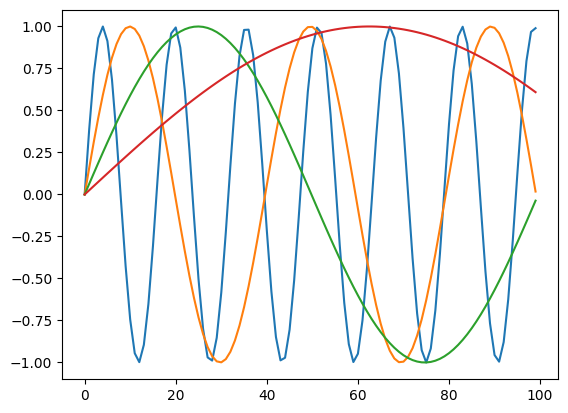

In [19]:
# Let's visualize
tst_encoding = PositionalEncoding(20)
res = tst_encoding(torch.arange(0,100).float())
#res.shape
_, ax = plt.subplots(1,1)
for i in range(1,5): ax.plot(res[:,i]) # Each dimension (i) corresponds to a sinusoid of different frequency

In [20]:
res[:20,:3] # Each column corresponds to a sinusoid
#res.shape

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.8415,  0.3877,  0.1578],
        [ 0.9093,  0.7147,  0.3117],
        [ 0.1411,  0.9300,  0.4578],
        [-0.7568,  0.9998,  0.5923],
        [-0.9589,  0.9132,  0.7121],
        [-0.2794,  0.6838,  0.8140],
        [ 0.6570,  0.3474,  0.8954],
        [ 0.9894, -0.0433,  0.9545],
        [ 0.4121, -0.4272,  0.9896],
        [-0.5440, -0.7443,  0.9999],
        [-1.0000, -0.9450,  0.9851],
        [-0.5366, -0.9979,  0.9457],
        [ 0.4202, -0.8947,  0.8825],
        [ 0.9906, -0.6516,  0.7973],
        [ 0.6503, -0.3066,  0.6920],
        [-0.2879,  0.0864,  0.5694],
        [-0.9614,  0.4659,  0.4325],
        [-0.7510,  0.7725,  0.2848],
        [ 0.1499,  0.9583,  0.1299]])

In [21]:
# Add the positional embeddings
class TransformerEmbedding(nn.Module):
    "Embedding + positional encoding + dropout"
    def __init__(self, vocab_sz, emb_sz, inp_p=0.):
        super().__init__()
        self.emb_sz = emb_sz
        self.embed = embedding(vocab_sz, emb_sz)
        self.pos_enc = PositionalEncoding(emb_sz)
        self.drop = nn.Dropout(inp_p)

    def forward(self, inp):
        pos = torch.arange(0, inp.size(1), device=inp.device).float()
        return self.drop(self.embed(inp) * math.sqrt(self.emb_sz) + self.pos_enc(pos))

### Multi-head attention

![Multi head attention](https://github.com/fastai/course-nlp/blob/master/images/attention.png?raw=1)

*   **Making Q, K, V**

![Matmul](http://jalammar.github.io/images/t/self-attention-matrix-calculation.png)

*   **Scaling and Softmax**

![Matmul](http://jalammar.github.io/images/t/self-attention-matrix-calculation-2.png)

In [22]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, d_head=None, p=0., bias=True, scale=True):
        super().__init__()
        d_head = ifnone(d_head, d_model//n_heads)
        self.n_heads,self.d_head,self.scale = n_heads,d_head,scale
        self.q_wgt, self.k_wgt, self.v_wgt = [nn.Linear(d_model, n_heads * d_head, bias=bias)
                                                                              for o in range(3)]

        self.out = nn.Linear(n_heads * d_head, d_model, bias=bias)
        self.drop_att, self.drop_res = nn.Dropout(p), nn.Dropout(p)
        self.ln = nn.LayerNorm(d_model)

    def forward(self, q, kv, mask=None):
        return self.ln(q + self.drop_res(self.out(self._apply_attention(q, kv, mask=mask))))

    def create_attn_mat(self, x, layer, bs):
        # Map embeddings into q, k, v vectors
        # 1. linear matmul of x with w_q, w_k, w_v
        # 2. reshape(to get multiple heads)
        return layer(x).view(bs, x.size(1), self.n_heads, self.d_head
                            ).permute(0, 2, 1, 3)

    def _apply_attention(self, q, kv, mask=None):
        bs, seq_len = q.size(0), q.size(1)
        wq, wk, wv = map(lambda o: self.create_attn_mat(*o, bs),
                         zip((q, kv, kv), (self.q_wgt, self.k_wgt, self.v_wgt))) # q <-> self.q_wgt, kv <-> self.k_wgt, kv <-> self.v_wgt

        attn_score = wq @ wk.transpose(2,3)
        if self.scale:
          attn_score /= math.sqrt(self.d_head)

        if mask is not None:
            attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score)

        attn_prob = self.drop_att(F.softmax(attn_score, dim=-1))
        attn_vec = attn_prob @ wv
        return attn_vec.permute(0, 2, 1, 3).contiguous().view(bs, seq_len, -1)

# Layer Normalization
![Positional Embedding](https://i.imgur.com/muMke6j.png)

### Feed forward

The feed forward cell is easy: it's just two linear layers with a skip connection and a LayerNorm.

In [23]:
def feed_forward(d_model, d_ff, ff_p=0., double_drop=True):
    layers = [nn.Linear(d_model, d_ff), nn.ReLU()]
    if double_drop: layers.append(nn.Dropout(ff_p))
    return SequentialEx(*layers, nn.Linear(d_ff, d_model), nn.Dropout(ff_p), MergeLayer(), nn.LayerNorm(d_model))

### Masking

The attention layer uses a mask to avoid paying attention to certain timesteps. The first thing is that we don't really want the network to pay attention to the padding, so we're going to mask it. The second thing is that since this model isn't recurrent, we need to mask (in the output) all the tokens we're not supposed to see yet (otherwise it would be cheating).

In [24]:
def get_output_mask(inp, pad_idx=1):
    return torch.triu(inp.new_ones(inp.size(1),inp.size(1)), diagonal=1)[None,None].byte()
#     return ((inp == pad_idx)[:,None,:,None].long() + torch.triu(inp.new_ones(inp.size(1),inp.size(1)), diagonal=1)[None,None] != 0)

Example of mask for the future tokens:

In [25]:
# Let's check what triangle upper looks like
torch.triu(torch.ones(10,10), diagonal=1).byte()

tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.uint8)

### Encoder and decoder blocks

We are now ready to regroup these layers in the blocks we add in the model picture:

![Transformer model](https://github.com/fastai/course-nlp/blob/master/images/Transformer.png?raw=1)

In [26]:
class EncoderBlock(nn.Module):
    "Encoder block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, n_heads, d_model, d_head, d_inner, p=0., bias=True, scale=True, double_drop=True):
        super().__init__()
        self.mha = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.ff  = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)

    def forward(self, x, mask=None): return self.ff(self.mha(x, x, mask=mask))

In [27]:
class DecoderBlock(nn.Module):
    "Decoder block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, n_heads, d_model, d_head, d_inner, p=0., bias=True, scale=True, double_drop=True):
        super().__init__()
        self.mha1 = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.mha2 = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.ff   = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)

    def forward(self, x, enc, mask_out=None): return self.ff(self.mha2(self.mha1(x, x, mask_out), enc))

### The whole model

In [28]:
class Transformer(Module):
    def __init__(self, inp_vsz, out_vsz, n_layers=6, n_heads=8, d_model=256, d_head=32,
                 d_inner=1024, p=0.1, bias=True, scale=True, double_drop=True, pad_idx=1):
        self.enc_emb = TransformerEmbedding(inp_vsz, d_model, p)
        self.dec_emb = TransformerEmbedding(out_vsz, d_model, 0.)
        args = (n_heads, d_model, d_head, d_inner, p, bias, scale, double_drop)
        self.encoder = nn.ModuleList([EncoderBlock(*args) for _ in range(n_layers)])
        self.decoder = nn.ModuleList([DecoderBlock(*args) for _ in range(n_layers)])
        self.out = nn.Linear(d_model, out_vsz)
        self.out.weight = self.dec_emb.embed.weight
        self.pad_idx = pad_idx

    def forward(self, inp, out):
        mask_out = get_output_mask(out, self.pad_idx)
        enc,out = self.enc_emb(inp),self.dec_emb(out)
        enc = compose(self.encoder)(enc)
        out = compose(self.decoder)(out, enc, mask_out)
        return self.out(out)

#### Bleu metric (see dedicated notebook)

In [29]:
class NGram():
    def __init__(self, ngram, max_n=5000): self.ngram,self.max_n = ngram,max_n
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))

def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams,targ_grams = get_grams(pred, n, max_n=max_n),get_grams(targ, n, max_n=max_n)
    pred_cnt,targ_cnt = Counter(pred_grams),Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g,c in pred_cnt.items()]),len(pred_grams)

class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'

    def on_epoch_begin(self, **kwargs):
        self.pred_len,self.targ_len,self.corrects,self.counts = 0,0,[0]*4,[0]*4

    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred,targ in zip(last_output.cpu().numpy(),last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c,t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i]   += t

    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c,t in zip(self.corrects,self.counts)]
        len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)

### Training

In [30]:
n_x_vocab,n_y_vocab = len(data.train_ds.x.vocab.itos), len(data.train_ds.y.vocab.itos)

model = Transformer(n_x_vocab, n_y_vocab, d_model=256)
learn = Learner(data, model, metrics=[accuracy, CorpusBLEU(n_y_vocab)], loss_func = CrossEntropyFlat())

epoch,train_loss,valid_loss,accuracy,bleu,time


/usr/local/lib/python3.10/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
<ipython-input-22-c4d7a7db67a9>:33: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/cuda/Indexing.cu:1440.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


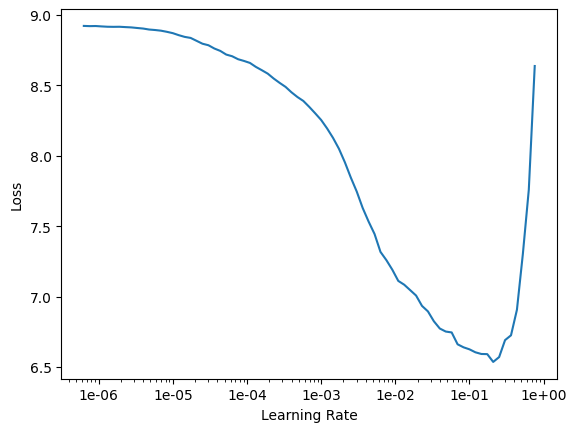

In [31]:
learn.lr_find()
learn.recorder.plot()

In [32]:
# Takes 7 minutes
learn.fit_one_cycle(8, 5e-4, div_factor=5)

epoch,train_loss,valid_loss,accuracy,bleu,time
0,2.522406,2.699466,0.589040,0.437003,01:05
1,2.130975,2.163092,0.660884,0.475865,01:04
2,1.655896,1.813180,0.702474,0.516831,01:05
3,1.428748,1.581684,0.730407,0.545216,01:06
4,1.201617,1.464022,0.747061,0.564079,01:05
5,1.006098,1.398557,0.758198,0.579423,01:04
6,0.882358,1.386429,0.762650,0.586067,01:05
7,0.817271,1.389844,0.763367,0.587210,01:06


<ipython-input-22-c4d7a7db67a9>:33: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/cuda/Indexing.cu:1440.)
  attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score)


In [33]:
def convert_to_string(output):
  return [str(item) for item in output]

def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(*xb)
            for x,y,z in zip(xb[0],xb[1],out):
                x = x.cpu()
                y = y.cpu()
                z = z.cpu()
                inputs.append(learn.data.train_ds.x.reconstruct(x))
                targets.append(learn.data.train_ds.y.reconstruct(y))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
    #return inputs, targets, outputs

    return convert_to_string(inputs), convert_to_string(targets), convert_to_string(outputs)

In [34]:
inputs, targets, outputs = get_predictions(learn)

<ipython-input-22-c4d7a7db67a9>:33: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/cuda/Indexing.cu:1440.)
  attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score)


In [35]:
inputs[10],targets[10],outputs[10]

('xxbos quelles méthodes a - t - on trouvées particulièrement efficaces pour consulter le public et les parties intéressées sur la protection des renseignements personnels reliés à la santé ?',
 'xxbos what approaches have been found particularly effective in consulting with the public and stakeholders on the protection of personal health information ?',
 'xxbos what methods have been particularly particularly effective in the the the public and stakeholders to health health of personal health information ?')

In [36]:
inputs[700],targets[700],outputs[700]

("xxbos qui a le pouvoir de modifier le règlement sur les poids et mesures et le règlement sur l'inspection de l'électricité et du gaz ?",
 'xxbos who has the authority to change the electricity and gas inspection regulations and the weights and measures regulations ?',
 'xxbos who has the authority to change the weight and the measures process and the food of gas of ?')

In [37]:
inputs[701],targets[701],outputs[701]

('xxbos ´ ` ou sont xxunk leurs grandes convictions en ce qui a trait a la ` ` ´ transparence et a la responsabilite ?',
 'xxbos what happened to their great xxunk about transparency and accountability ?',
 'xxbos what are to their main strengths , transparency and transparency ?')

In [38]:
inputs[2500],targets[2500],outputs[2500]

('xxbos de quoi l’afrique a - t - elle vraiment besoin pour se sortir de la pauvreté ?',
 'xxbos what does africa really need to pull itself out of poverty ?',
 'xxbos what does africa really need to raise out out of poverty ?')

In [39]:
inputs[4002],targets[4002],outputs[4002]

('xxbos quelles ressources votre communauté possède - t - elle qui favoriseraient la guérison ?',
 'xxbos what resources exist in your community that would promote recovery ?',
 'xxbos what resources does in your community that would encourage the of')

### Label smoothing

They point out in the paper that using label smoothing helped getting a better BLEU/accuracy, even if it made the loss worse.

In [40]:
model = Transformer(len(data.train_ds.x.vocab.itos), len(data.train_ds.y.vocab.itos), d_model=256)
learn = Learner(data, model, metrics=[accuracy, CorpusBLEU(len(data.train_ds.y.vocab.itos))],
                loss_func=FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1))
learn.fit_one_cycle(8, 5e-4, div_factor=5)

epoch,train_loss,valid_loss,accuracy,bleu,time
0,3.464089,3.564911,0.590340,0.440163,01:04
1,2.997701,3.107935,0.663642,0.482593,01:07
2,2.692048,2.798379,0.705038,0.517479,01:04
3,2.474375,2.614036,0.732416,0.547135,01:06
4,2.326970,2.516146,0.749581,0.567554,01:06
5,2.141249,2.468149,0.758173,0.579654,01:06
6,2.019990,2.461409,0.762781,0.584912,01:05
7,1.959522,2.461623,0.763196,0.586156,01:06


<ipython-input-22-c4d7a7db67a9>:33: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/cuda/Indexing.cu:1440.)
  attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score)


In [41]:
print("Quels sont les atouts particuliers du Canada en recherche sur l'obésité sur la scène internationale ?")
print("What are Specific strengths canada strengths in obesity - ? are up canada ? from international international stage ?")
print("Quelles sont les répercussions politiques à long terme de cette révolution scientifique mondiale ?")
print("What are the long the long - term policies implications of this global scientific ? ?")

Quels sont les atouts particuliers du Canada en recherche sur l'obésité sur la scène internationale ?
What are Specific strengths canada strengths in obesity - ? are up canada ? from international international stage ?
Quelles sont les répercussions politiques à long terme de cette révolution scientifique mondiale ?
What are the long the long - term policies implications of this global scientific ? ?


In [42]:
inputs[10],targets[10],outputs[10]

('xxbos quelles méthodes a - t - on trouvées particulièrement efficaces pour consulter le public et les parties intéressées sur la protection des renseignements personnels reliés à la santé ?',
 'xxbos what approaches have been found particularly effective in consulting with the public and stakeholders on the protection of personal health information ?',
 'xxbos what methods have been particularly particularly effective in the the the public and stakeholders to health health of personal health information ?')

In [43]:
inputs[700],targets[700],outputs[700]

("xxbos qui a le pouvoir de modifier le règlement sur les poids et mesures et le règlement sur l'inspection de l'électricité et du gaz ?",
 'xxbos who has the authority to change the electricity and gas inspection regulations and the weights and measures regulations ?',
 'xxbos who has the authority to change the weight and the measures process and the food of gas of ?')

In [44]:
inputs[701],targets[701],outputs[701]

('xxbos ´ ` ou sont xxunk leurs grandes convictions en ce qui a trait a la ` ` ´ transparence et a la responsabilite ?',
 'xxbos what happened to their great xxunk about transparency and accountability ?',
 'xxbos what are to their main strengths , transparency and transparency ?')

In [45]:
inputs[4001],targets[4001],outputs[4001]

('xxbos pourquoi parcs canada mise - t - il autant sur la participation locale ?',
 'xxbos why is parks canada focused so much on local input ?',
 'xxbos why is parks canada so on long local local participation ?')

### Test leakage

If we change a token in the targets at position n, it shouldn't impact the predictions before that.

In [ ]:
learn.model.eval();

In [ ]:
xb,yb = data.one_batch(cpu=False)

In [ ]:
inp1,out1 = xb[0][:1],xb[1][:1]
inp2,out2 = inp1.clone(),out1.clone()
out2[0,15] = 10

In [ ]:
y1 = learn.model(inp1, out1)
y2 = learn.model(inp2, out2)

In [ ]:
(y1[0,:15] - y2[0,:15]).abs().mean()